In [6]:
from preamble import *

In [8]:
data = pd.read_csv('./data/j_weather_data_v2.csv')
data = data.drop('snow', axis=1)
data['datetime'] = pd.to_datetime(data['datetime'])
data.loc[data['outflow'] <= 1, 'outflow'] = np.nan
median_value = data['outflow'].median()
data['outflow'] = data['outflow'].fillna(median_value)

In [9]:
target_variable = 'outflow'

data_temp = data.copy()
data_temp['outflow_diff'] = data_temp[target_variable].diff().abs()
limit = 0.001 # df_temp['outflow_diff'][2019] = 0.0014899999996487168

flat_regions = []
start_index = None
for i, diff in enumerate(data_temp['outflow_diff']):
  if diff <= limit:
    if start_index is None:
      start_index = i
  elif start_index is not None:
    flat_regions.append((start_index, i - 1))
    start_index = None

if start_index is not None:
  flat_regions.append((start_index, len(df) -1))

threshold = data_temp['outflow_diff'].mean() + 2 * data_temp['outflow_diff'].std()
anomaly_indices = data_temp[data_temp['outflow_diff'] > threshold].index.tolist()

data_dropped = data_temp.drop(index=range(12303, 12515)).reset_index(drop=True)
data_replace = data_dropped.drop('outflow_diff', axis=1)
for index in anomaly_indices:
  if index > 0 and index < len(data_replace) :
    data_replace.loc[index, target_variable] = data_replace.loc[index-1, target_variable]
  elif index == 0 and len(data_replace) > 1:
    data_replace.loc[index, target_variable] = data_replace.loc[index+1, target_variable]
data_cleaned = data_replace.copy()

In [10]:
def create_time_feature(df): 
  df['dayofmonth'] = df['datetime'].dt.day 
  df['dayofweek'] = df['datetime'].dt.dayofweek 
  df['dayofyear'] = df['datetime'].dt.dayofyear 
  df['hour'] = df['datetime'].dt.hour
  df['minute'] = df['datetime'].dt.minute
  df['second'] = df['datetime'].dt.second
  return df

df = create_time_feature(data_cleaned)
df = df.drop('datetime', axis=1)

In [11]:
def create_sequences(data, seq_length, target_length):
  Xs = []
  ys = []
  for i in range(len(data) - seq_length - target_length + 1):
    X = data[i:(i + seq_length)].drop('outflow', axis=1).values
    y = data['outflow'].values[i + seq_length: i+ seq_length + target_length]
    Xs.append(X)
    ys.append(y)
  return np.array(Xs), np.array(ys)

In [12]:
# 파라미터 설정
SEQ_LENGTH = 168  # 과거 7일 (시간 단위)
TARGET_LENGTH = 24 # 이후 24시간 예측

In [13]:
# Sequential Dataset 생성
X, y = create_sequences(df, SEQ_LENGTH, TARGET_LENGTH)

In [15]:
train_size = int(len(X) * 0.7)
valid_size = int(train_size * 0.1)

X_train, X_test = X[:(train_size - valid_size)], X[train_size:]
y_train, y_test = y[:(train_size - valid_size)], y[train_size:]
X_valid, y_valid = X[(train_size - valid_size):train_size], y[(train_size - valid_size):train_size]

In [11]:
import xgboost as xgb

# XGBoost 모델 학습
reg = xgb.XGBRegressor(n_estimators=1000, eval_metric="rmse", early_stopping_rounds=50)
reg.fit(
  X_train.reshape(X_train.shape[0], -1), 
  y_train.reshape(-1),
  eval_set=[(X_valid.reshape(X_valid.shape[0], -1), y_valid.reshape(-1))],  # 평가 데이터 설정
  verbose=50,  # 50 에포크마다 진행률 출력
)

[0]	validation_0-rmse:2166.28487
[50]	validation_0-rmse:1837.53817
[60]	validation_0-rmse:1847.80220


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [3]:
# model_filename = 'D:/OptiFlow/OptiFlowData/model/xgboost_model.json'
# reg.save_model(model_filename)
import xgboost as xgb
model = xgb.Booster(model_file=model_filename)

In [4]:
def predict_future(model, last_window, target_length):
  last_window_reshaped = last_window.reshape(1, -1)
  dmatrix_input = xgb.DMatrix(last_window_reshaped)

  predictions = model.predict(dmatrix_input)

  return predictions.reshape(target_length)

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = np.array([predict_future(model, X_test[i], TARGET_LENGTH) for i in range(len(X_test))])

mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
rmse = np.sqrt(mse)
r2 = r2_score(y_test.reshape(-1), y_pred.reshape(-1))
print(f'MSE : {mse}, RMSE : {rmse} R-value : {r2}')

MSE : 4796291.410145183, RMSE : 2190.0437005103763 R-value : 0.2559538633311115


In [25]:
y_test_plot = np.concatenate((y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5], y_test[6]))
y_pred_plot = np.concatenate((y_pred[0], y_pred[1], y_pred[2], y_pred[3], y_pred[4], y_pred[5], y_pred[6]))

In [22]:
a = np.array([[1, 2], [3, 4]])

d = np.concatenate((a, np.array([[5], [6]])), axis=1)  # b의 shape을 맞춰줘야 함
print("수평 병합:\n", d)

수평 병합:
 [[1 2 5]
 [3 4 6]]


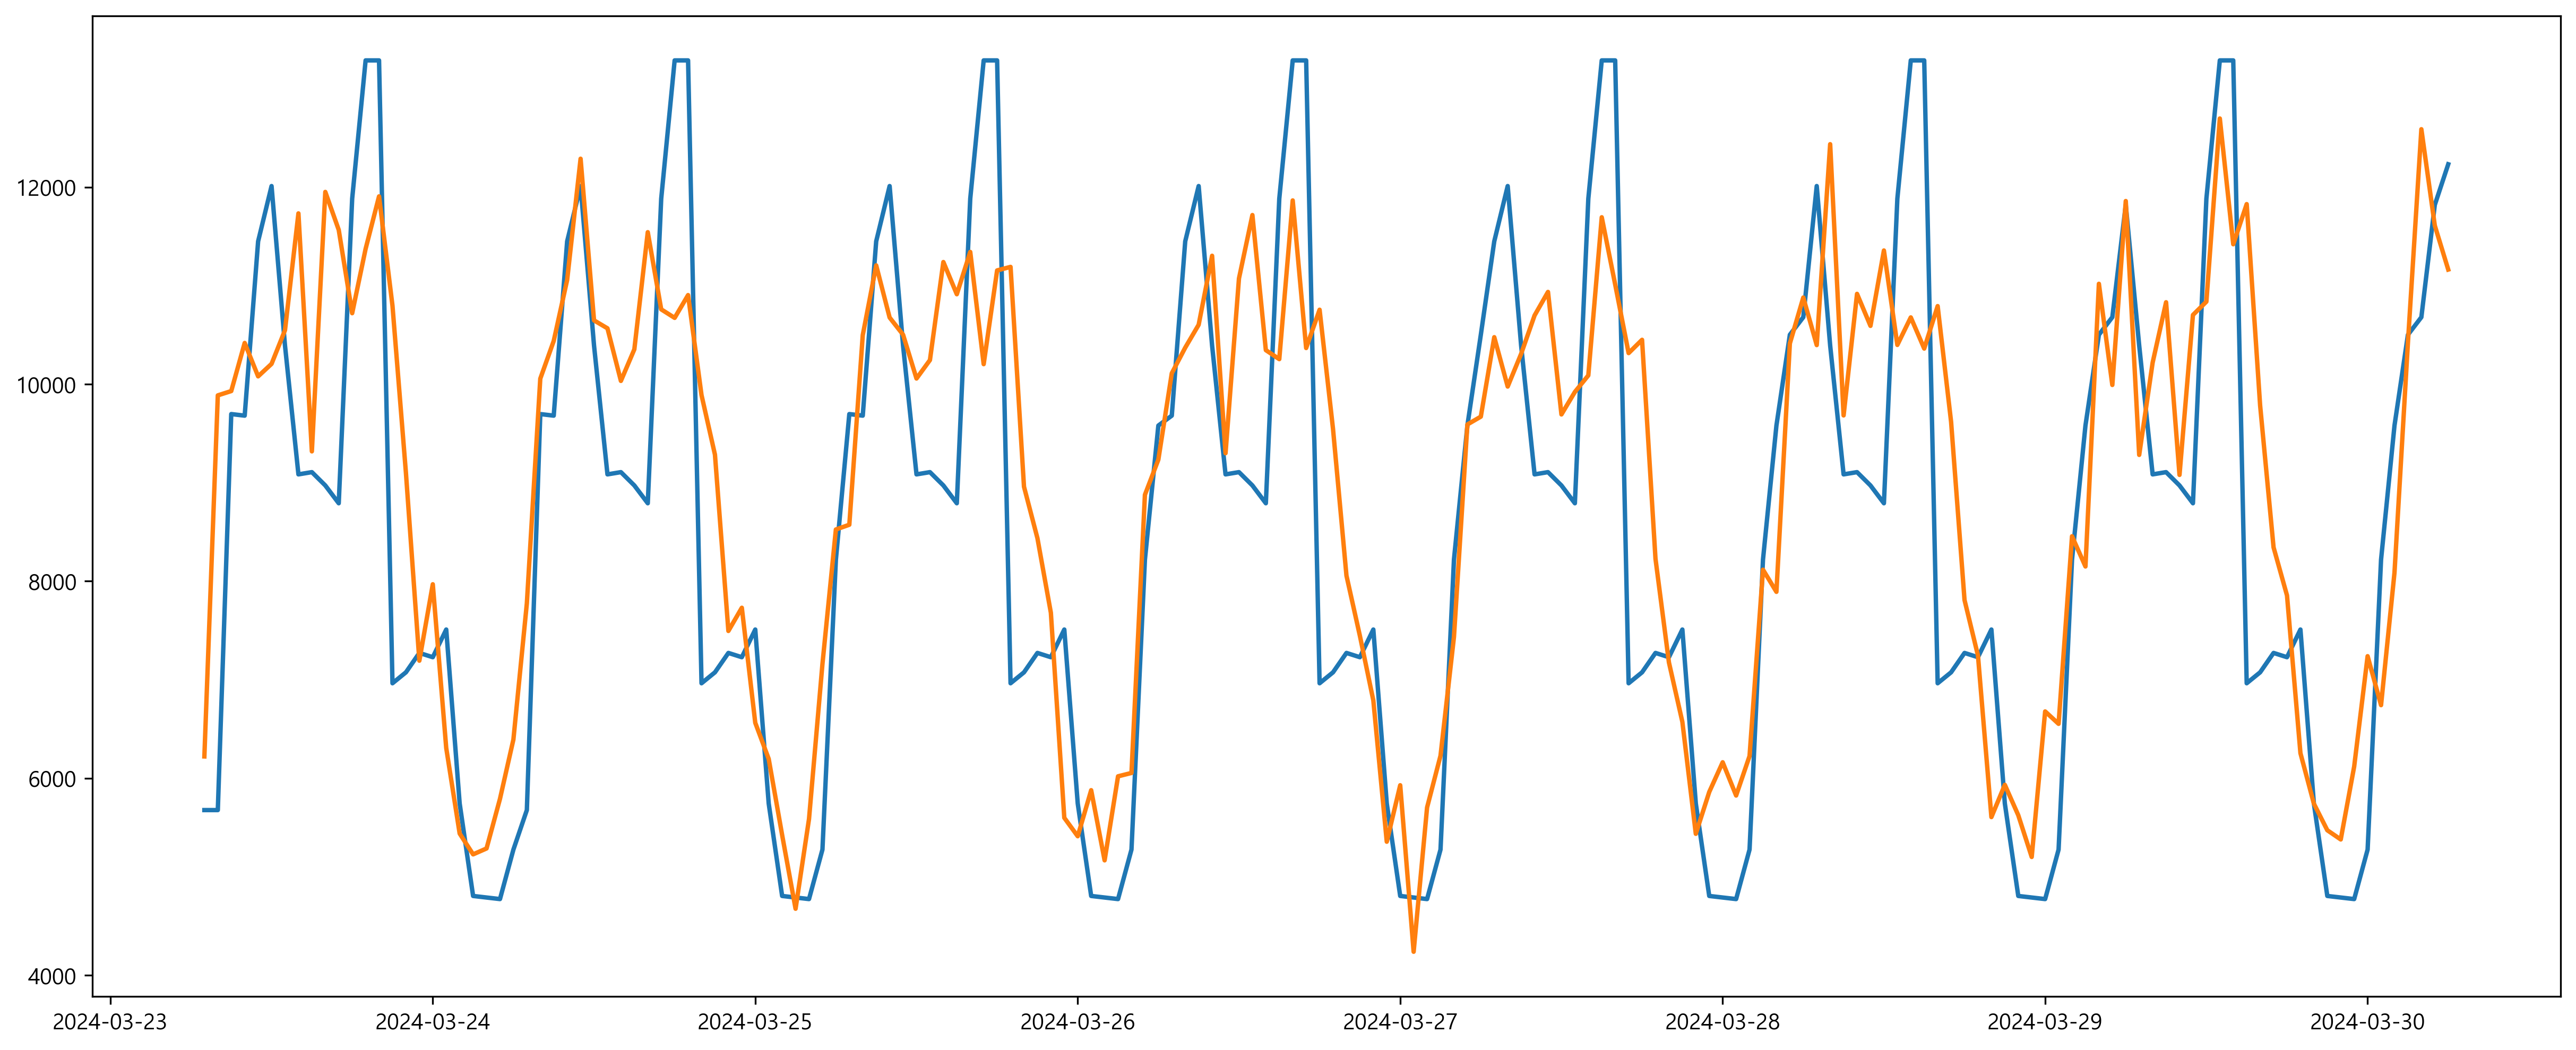

In [26]:
plt.figure(figsize=(20, 8))
plt.plot(data['datetime'][train_size:train_size + 168], y_test_plot)
plt.plot(data['datetime'][train_size:train_size + 168], y_pred_plot)
plt.show()

In [27]:
y_test_plot_last = np.concatenate((y_test[-7], y_test[-6], y_test[-5], y_test[-4], y_test[-3], y_test[-2], y_test[-1]))
y_pred_plot_last = np.concatenate((y_pred[-7], y_pred[-6], y_pred[-5], y_pred[-4], y_pred[-3], y_pred[-2], y_pred[-1]))

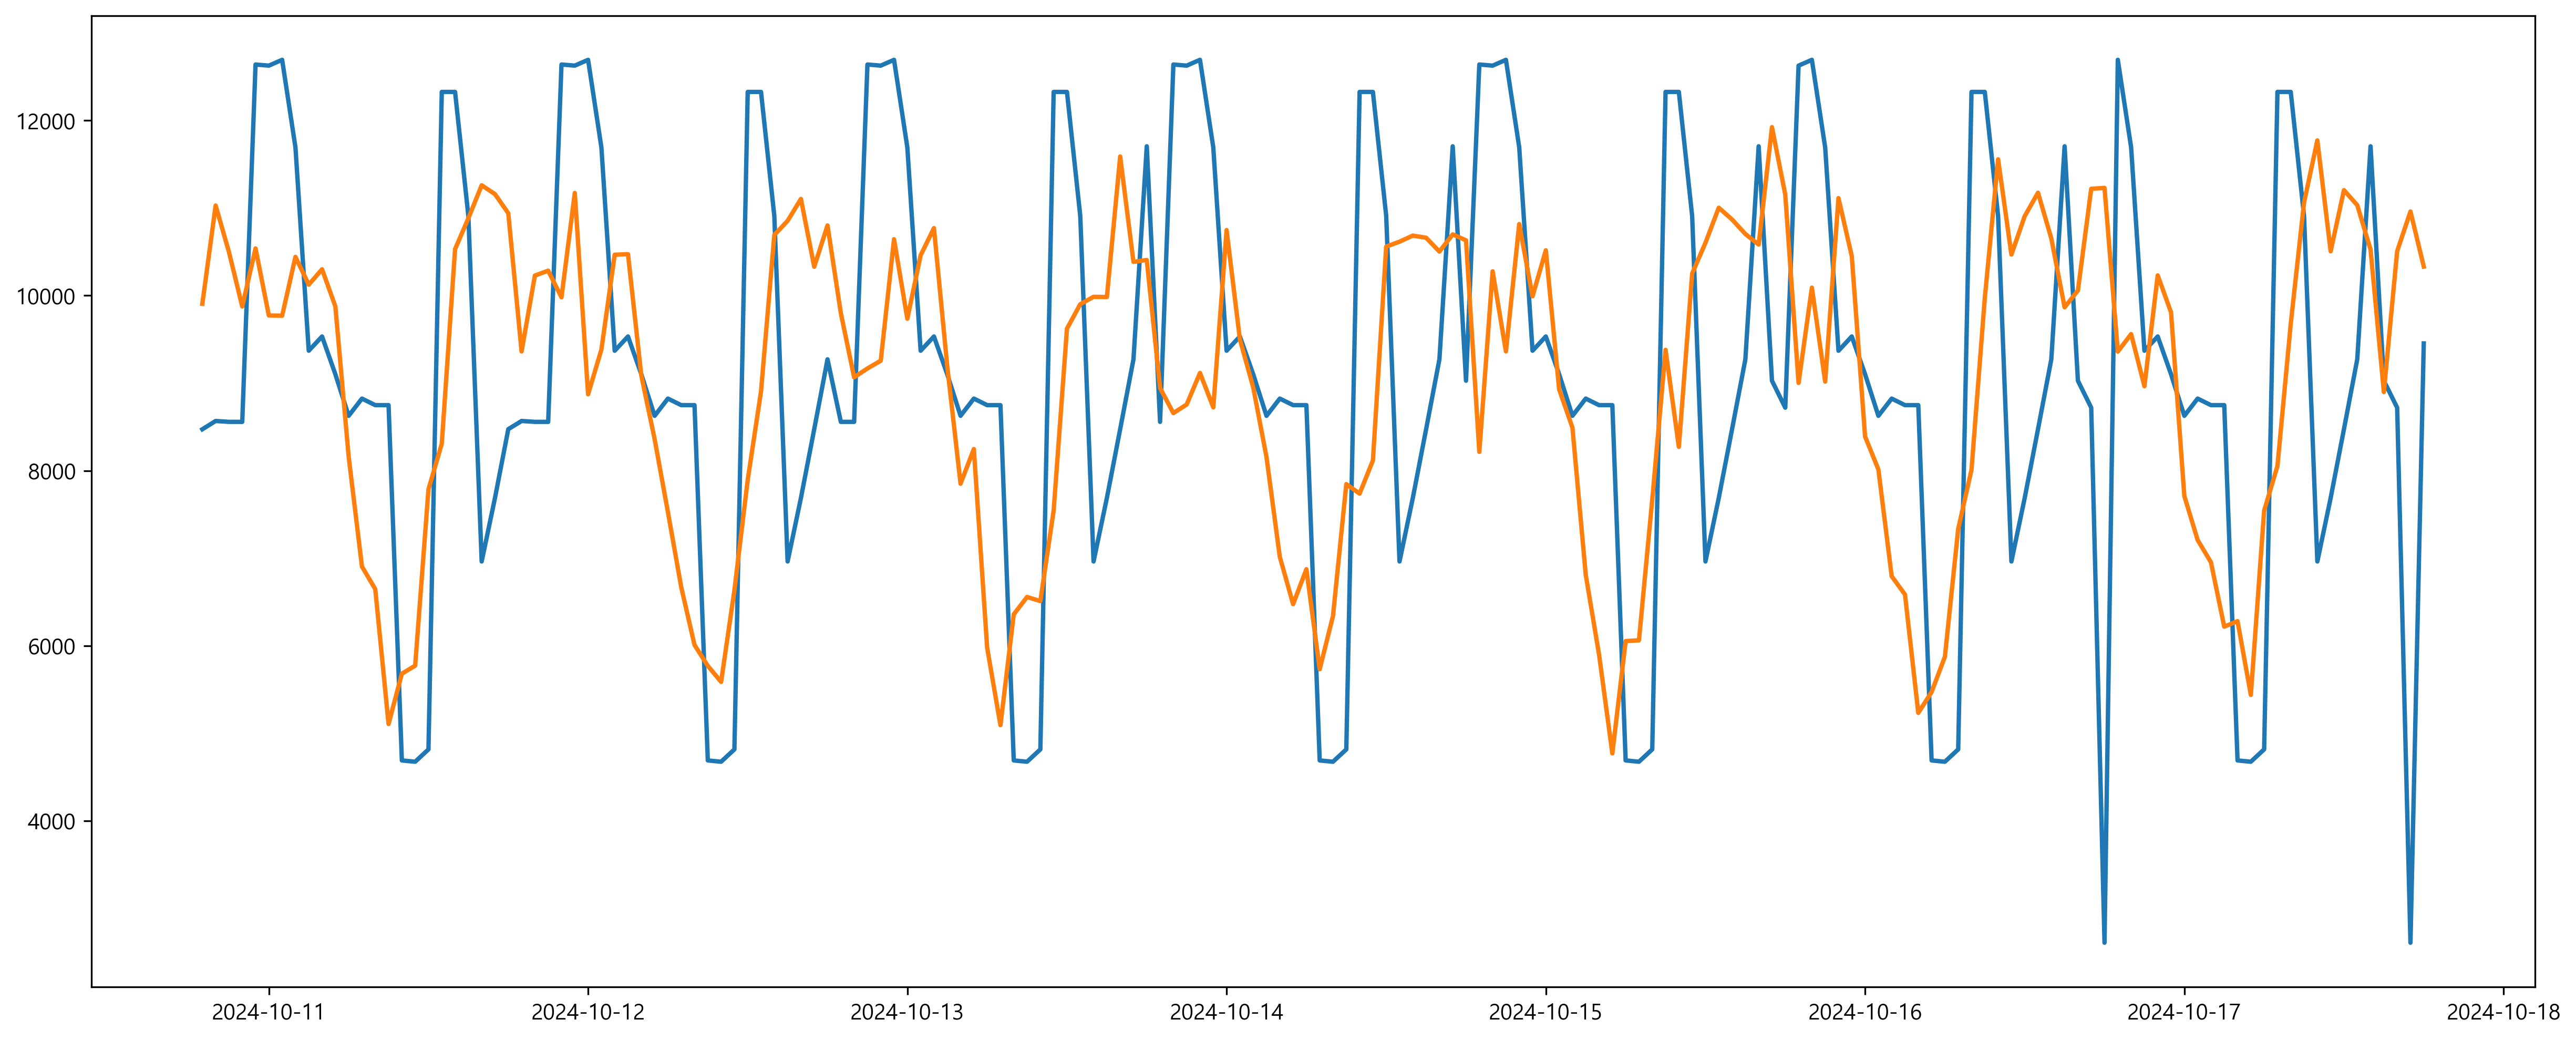

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(data['datetime'][-168:], y_test_plot_last)
plt.plot(data['datetime'][-168:], y_pred_plot_last)
plt.show()